In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

from tqdm import tqdm

from flash_ansr import get_path
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
# This is where the results are stored
PATH_TO_EVALUATION_DATA = get_path('results', 'evaluation')
os.path.exists(PATH_TO_EVALUATION_DATA)

True

In [3]:
# We will compare multiple series of experiments here, each model with different amounts of test time compute.
results = {
    'PySR': {'scaling_parameter': 'niterations'},
    'FlashANSR': {'scaling_parameter': 'choices'},  # For later
}

In [4]:
for model in results.keys():
    print(f"Processing model {model}")
    if not 'scaling_parameter' in results[model]:
        raise ValueError("Please specify the scaling parameter for the model.")
    scaling_parameter = results[model]['scaling_parameter']

    # In the directory, there are multiple directories named "evaluation_<scaling_parameter_name>_<scaling_parameter_value>.yaml",
    # each each containing files "<test_set_name>.pickle" with the evaluation results for a specific test set.
    evaluations_list = os.listdir(os.path.join(PATH_TO_EVALUATION_DATA, f'{model}_{scaling_parameter}'))

    evaluations_list = [d for d in evaluations_list if d.startswith(f'evaluation_{scaling_parameter}_')]
    scaling_values = [int(d.split('_')[-1].split('.')[0]) for d in evaluations_list]

    scaling_values_argsort = np.argsort(scaling_values)
    scaling_values = [scaling_values[i] for i in scaling_values_argsort]
    evaluations_list = [evaluations_list[i] for i in scaling_values_argsort]

    results[model]['scaling_values'] = scaling_values
    results[model]['evaluations_list'] = evaluations_list
    results[model]['results'] = {}

    print(f"Found {len(evaluations_list)} evaluations with scaling values: {scaling_values}")
    for d in evaluations_list:
        print(f" - {d}")

Processing model PySR
Found 5 evaluations with scaling values: [1, 2, 4, 8, 16]
 - evaluation_niterations_1.yaml
 - evaluation_niterations_2.yaml
 - evaluation_niterations_4.yaml
 - evaluation_niterations_8.yaml
 - evaluation_niterations_16.yaml


In [5]:
TEST_SETS_FILTER = ['pool_15_10']

In [6]:
# Load the evaluation results
for model in results.keys():
    for d in tqdm(results[model]['evaluations_list'], desc="Loading evaluation results"):
        for test_set in TEST_SETS_FILTER:
            path_to_pickle = os.path.join(PATH_TO_EVALUATION_DATA, f'{model}_{scaling_parameter}', d, f"{test_set}.pickle")
            if not os.path.exists(path_to_pickle):
                print(f"Warning: {path_to_pickle} does not exist. Skipping.")
                continue
            with open(path_to_pickle, 'rb') as f:
                result = pickle.load(f)
            niterations = int(d.split('_')[-1].split('.')[0])
            if test_set not in results[model]['results']:
                results[model]['results'][test_set] = {}
            results[model]['results'][test_set][niterations] = result

    print(results[model]['results'].keys())

Loading evaluation results: 100%|██████████| 5/5 [00:00<00:00, 13.35it/s]

dict_keys(['pool_15_10'])


In [7]:
for model in results.keys():
    for test_set in results[model]['results'].keys():
        for niterations in results[model]['results'][test_set].keys():
            for metric in results[model]['results'][test_set][niterations].keys():
                try:
                    results[model]['results'][test_set][niterations][metric] = np.array(results[model]['results'][test_set][niterations][metric])
                except ValueError:
                    pass  # setting an array element with a sequence

In [8]:
print(results['PySR']['results']['pool_15_10'][1].keys())

dict_keys(['best_skeleton', 'best_skeleton_decoded', 'best_skeleton_simplified_decoded', 'constants', 'expression', 'fit_time', 'input_ids', 'labels', 'labels_decoded', 'n_support', 'skeleton', 'skeleton_hash', 'x', 'x_val', 'y', 'y_pred', 'y_pred_val', 'y_val'])


In [9]:
def safe_divide(a, b):
    if b == 0:
        if a == 0:
            return 0
        return np.inf
    return a / b

def fvu(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true, keepdims=True)) ** 2)
    fvu = safe_divide(ss_res, ss_tot)
    return fvu

def log10_fvu(y_true, y_pred):
    fvu_value = fvu(y_true, y_pred)
    if fvu_value == 0:
        return -np.inf
    return np.log10(fvu_value)

def is_perfect_fit(y_true, y_pred):
    return log10_fvu(y_true, y_pred) <= np.finfo(np.float32).eps


for model in results.keys():
    for test_set in results[model]['results'].keys():
        for niterations in results[model]['results'][test_set].keys():
            for split, saved_split_name in zip(['fit', 'val'], ['', '_val']):
                results[model]['results'][test_set][niterations][f'fvu_{split}'] = np.array(
                    [fvu(y_true, y_pred) for y_true, y_pred in zip(
                        results[model]['results'][test_set][niterations][f'y{saved_split_name}'],
                        results[model]['results'][test_set][niterations][f'y_pred{saved_split_name}'])])
                
                results[model]['results'][test_set][niterations][f'log10_fvu_{split}'] = np.array(
                    [log10_fvu(y_true, y_pred) for y_true, y_pred in zip(
                        results[model]['results'][test_set][niterations][f'y{saved_split_name}'],
                        results[model]['results'][test_set][niterations][f'y_pred{saved_split_name}'])])
                                
                results[model]['results'][test_set][niterations][f'is_perfect_fit_{split}'] = np.array(
                    [is_perfect_fit(y_true, y_pred) for y_true, y_pred in zip(
                        results[model]['results'][test_set][niterations][f'y{saved_split_name}'],
                        results[model]['results'][test_set][niterations][f'y_pred{saved_split_name}'])])


print(results['PySR']['results']['pool_15_10'][1]['fvu_fit'][:4])

/tmp/ipykernel_39844/2198878124.py:10: RuntimeWarning: overflow encountered in square
  ss_tot = np.sum((y_true - np.mean(y_true, keepdims=True)) ** 2)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[1.00786069 1.11891624 1.00421229 1.15875545]


/tmp/ipykernel_39844/2198878124.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return a / b


In [10]:
results['PySR']['results']['pool_15_10'][1]['fvu_val'].shape, results['PySR']['results']['pool_15_10'][1]['fit_time'].shape

((4096,), (4096,))

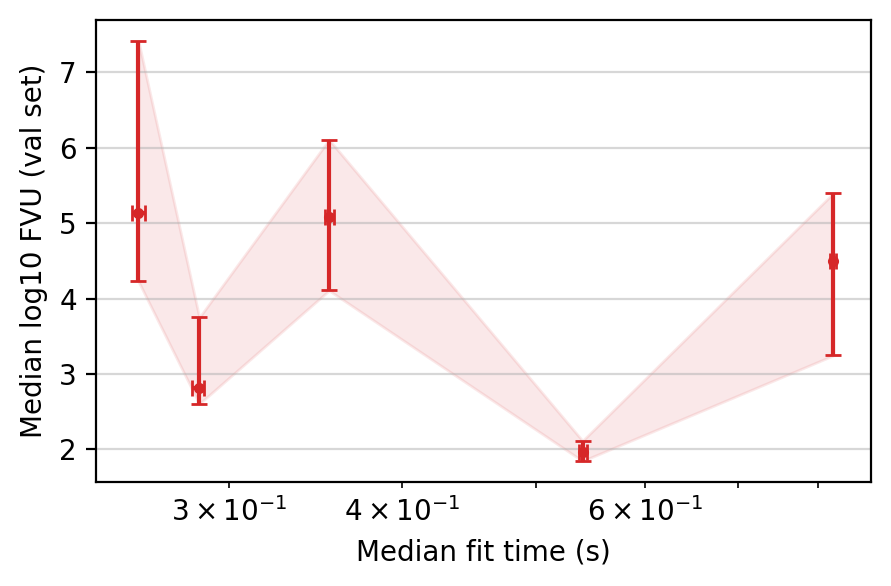

In [51]:
# x = [np.median(results['PySR']['results']['pool_15_10'][n]['x']) for n in results['PySR']['results']['pool_15_10'].keys()]
# y = [np.median(results['PySR']['results']['pool_15_10'][n]['log10_fvu_fit']) for n in results['PySR']['results']['pool_15_10'].keys()]

x_median = []
x_lower = []
x_upper = []
y_median = []
y_lower = []
y_upper = []

for n in results['PySR']['results']['pool_15_10'].keys():
    x = results['PySR']['results']['pool_15_10'][n]['fit_time']
    y = results['PySR']['results']['pool_15_10'][n]['fvu_val']
    y[y == -np.inf] = np.log10(np.finfo(np.float32).eps)  # Replace -inf with a very small number for bootstrapping
    
    x_ci = bootstrapped_metric_ci(x, np.nanmedian, n=1000, interval=0.95)
    y_ci = bootstrapped_metric_ci(y, np.nanmedian, n=1000, interval=0.95)
    
    x_median.append(x_ci[0])
    x_lower.append(x_ci[1])
    x_upper.append(x_ci[2])
    
    y_median.append(y_ci[0])
    y_lower.append(y_ci[1])
    y_upper.append(y_ci[2])

fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)
ax.errorbar(x_median, y_median, yerr=[np.array(y_median) - np.array(y_lower), 
                                                                 np.array(y_upper) - np.array(y_median)],
            xerr=[np.array(x_median) - np.array(x_lower), 
                  np.array(x_upper) - np.array(x_median)],
            fmt='.', label='PySR', capsize=3, color='tab:red')
ax.fill_between(x_median, y_lower, y_upper, color='tab:red', alpha=0.1)
ax.set_xlabel('Median fit time (s)')
ax.set_ylabel('Median log10 FVU (val set)')
ax.set_xscale('log')
ax.set_yscale('linear')

ax.grid(alpha=0.5)